## Magnetic Bottle
2D simulations of Single Particle Drifts


In [7]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

# get ZPIC 2D
import em2d_rr as em2d
import numpy as np

# import required libraries

import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Simulation time
tmax = 250
# Number of cells
nx  = [480+128,32]
#nx  = [960,64]
# Simulation box size
box = [18,0.5]

#Time step
def courant(dx,dy):
    return 1/np.sqrt(1/dx**2+1/dy**2)
dt = 0.999*courant(box[0]/nx[0],box[1]/nx[1])

# Particles per cell
ppc = [8,32]

def custom_nx(x):
    return 1.0 if (x>4.4 and x<4.6)  else 0.0

def custom_ny(x):
    return 1.0 if (x>0.24 and x<0.26) else 0.0

dens = em2d.Density( type = "custom", custom_x = custom_nx,custom_y = custom_ny  )
# Set up a super low density
dens.n=1e-6

ufl=0.05
#create the species
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[ufl,0,0],uth=[0,2*ufl,0])

# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons) )

electrons.n_sort=0

##### External fields

We will be using the python package ```loopfield``` to obtain the magnetic field coming from two current loops placed at the edges of the simulation box.

The current loops are placed in such a way that the plasma particles begin their motion in the middle of the bottle

In [9]:
import loopfield as lf
# create empty field with specified units
field = lf.Field(length_units = lf.cm,
                 current_units = lf.A,
                 field_units = lf.uT)

position = [9., 0.25, 0.]
#position = [9., 0.5, 0.]
normal = [1., 0., 0.]
radius = 2.6
current = 0.4
c = lf.Loop(position, normal, radius, current)

#position = [0., 0.5, 0.]
position = [0., 0.25, 0.]
d = lf.Loop(position, normal, radius, current)

# add loop to field
field.addLoop(c);
field.addLoop(d);

We pre-calculate the external field in order to save a bit of computing time

In [10]:
#Pre-caclculate the external fields 
gc=[[1,2],[1,2]]
external_fld=[]
for i in range(nx[0]+gc[0][0]+gc[0][1]):
    ix=i-1
    external_fld_col=[]
    for j in range(nx[1]+gc[1][0]+gc[1][1]):
        iy=j-1
        x = ix*sim.dx[0]       
        y = (iy+0.5)*sim.dx[1]
        bx= field.evaluate([x,y,0])[0]

        x = (ix+0.5)*sim.dx[0]
        y = iy*sim.dx[1]      
        by,bz= field.evaluate([x,y,0])[1:]
        external_fld_col.append([200*bx,200*by,200*bz])      
    
     
    external_fld.append(external_fld_col)
print("done calculating ext")

def ext_B(ix,dx,iy,dy):
    i = ix+1
    j=  iy+1
    return external_fld[i][j]

#ext = em2d.ExternalField(B_type = 'custom', B_custom = ext_B,E_type = 'uniform', E_0 = [0.01,0.01,0.01])
ext = em2d.ExternalField(B_type = 'custom', B_custom = ext_B,E_type = 'none')

#init = em2d.InitialField(E_type = 'uniform', E_0 = [0.01,0.01,0.01])
#sim.emf.init_fld( init )
sim.emf.set_ext_fld( ext )

done calculating ext


Here you can check the longitudinal profile of the magnetic field

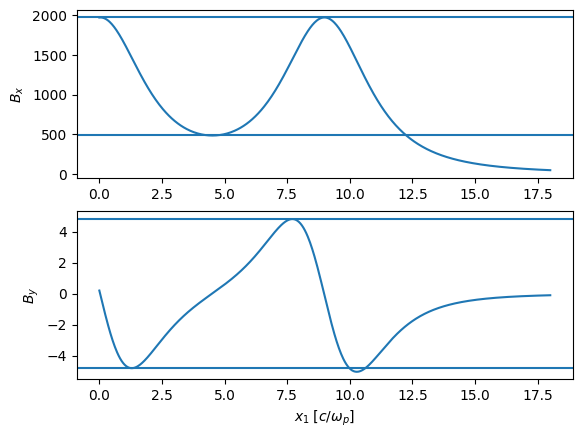

In [11]:
import matplotlib.pyplot as plt

x=np.linspace(0,box[0],nx[0]+gc[0][0]+gc[0][1])

fig, (ax1, ax2) = plt.subplots(2, 1)


ax1.plot(x,np.array(external_fld)[:,16,0],)
ax1.set_ylabel("$B_x$")
ax1.axhline(np.max(np.array(external_fld)[:,16,0]))
ax1.axhline(np.min(np.array(external_fld)[:150,16,0]))

ax2.plot(x,np.array(external_fld)[:,16,1],)
ax2.set_ylabel("$B_y$")
ax2.set_xlabel("$x_1\;[c/\omega_p]$")
ax2.axhline(np.max(np.array(external_fld)[:,16,1]))
ax2.axhline(np.min(np.array(external_fld)[:150,16,1]))


In [12]:
np.max(np.array(external_fld)[:,16,0])/np.min(np.array(external_fld)[:150,16,0])


4.070050821147602

Now running the simulation

In [13]:
#arays to store the particles trajectories
ele_part_rep =[]

while sim.t < 350:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    
    #store the electron trajectories
    if sim.n%10 ==0 :
        ele_part_rep.append(electrons.particles[:].copy())

    sim.iter()

### Checking the results

#### Plasma position.

As the simulation progresses, some plasma particles are able to leave the magnetic bottle and others bounce back.

In [14]:
# create output folder + frames folder

output_path  = 'output/'
os.system('mkdir '+output_path+' 2> /dev/null')
os.system('mkdir '+output_path+'frames 2> /dev/null')


# name of the output file

filename = 'movie_example'

In [15]:
# movie parameters

fps = 20      # frames per second
n_frames = 1500 # total number of frames; the movie lenght will be = n_frames/fps

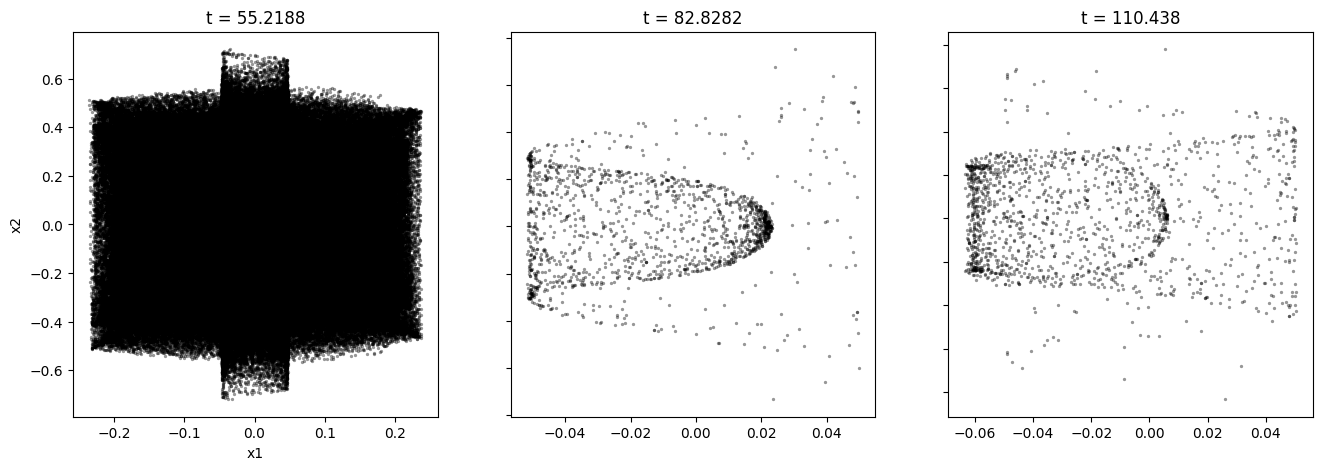

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# # Position
# x = lambda s : (s['ix'] + s['x']) * sim.dx[0] 
# y = lambda s : (s['iy'] + s['y']) * sim.dx[1]

#Momentum
x = lambda s : ( s['ux'])  
y = lambda s : ( s['uy']) 

xscat_0 = []
yscat_0 = []

for i in range(len(ele_part_rep)):
    aux_x = [x(ai) for ai in ele_part_rep[i]]
    aux_y = [y(ai) for ai in ele_part_rep[i]]
    xscat_0.append(aux_x)
    yscat_0.append(aux_y)

axes[0].scatter(xscat_0, yscat_0, c="k", alpha=0.4, lw=0.1, s=5)

xscat_1=[x(ai) for ai in ele_part_rep[600]]
yscat_1=[y(ai) for ai in ele_part_rep[600]]
axes[1].scatter(xscat_1,yscat_1,c="k",alpha=0.4,lw=0.1,s=5)

xscat_2=[x(ai) for ai in ele_part_rep[900]]
yscat_2=[y(ai) for ai in ele_part_rep[900]]
axes[2].scatter(xscat_2,yscat_2,c="k",alpha=0.4,lw=0.1,s=5)
    
axes[0].set_title("t = {:g}".format(dt*4000))
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*6000))
axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*8000))

#axes.set_title("Dstribution function without RR at t = {:g}".format(dt*0))

axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")


plt.show()

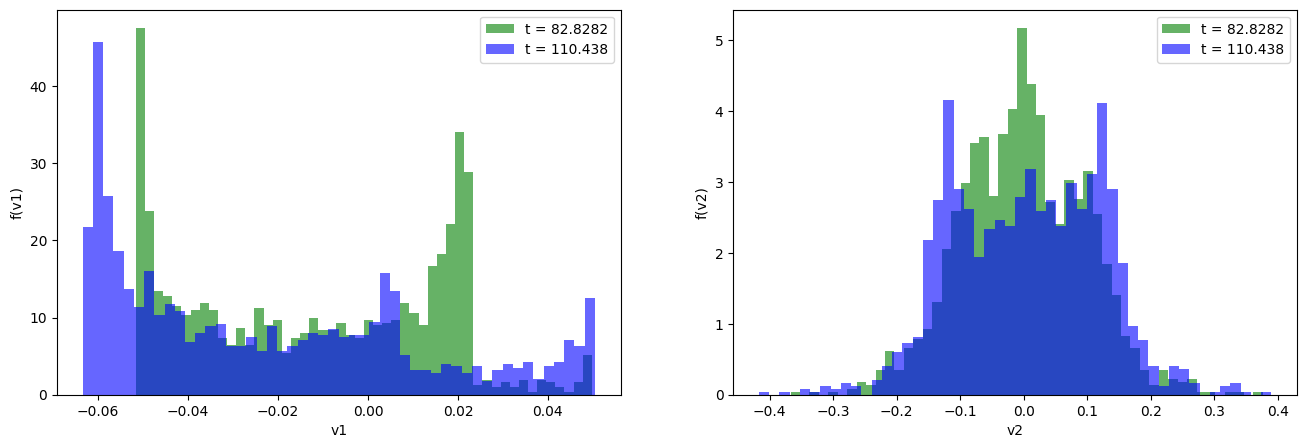

In [41]:
# integrate the velocity in x1
v1 = lambda s : s['ux']
v2 = lambda s : s['uy']

v1_1 = [v1(ai) for ai in ele_part_rep[600]]
v2_1 = [v2(ai) for ai in ele_part_rep[600]]

v1_2 = [v1(ai) for ai in ele_part_rep[900]]
v2_2 = [v2(ai) for ai in ele_part_rep[900]]


# Plot the distribution function, normalized to the number of particles
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axes[0].hist(v1_1, bins=50, density=True, alpha=0.6, color='g', label='t = {:g}'.format(dt*6000))
axes[0].hist(v1_2, bins=50, density=True, alpha=0.6, color='b', label='t = {:g}'.format(dt*8000))
axes[0].set_xlabel("v1")
axes[0].set_ylabel("f(v1)")
axes[0].legend()

axes[1].hist(v2_1, bins=50, density=True, alpha=0.6, color='g', label='t = {:g}'.format(dt*6000))
axes[1].hist(v2_2, bins=50, density=True, alpha=0.6, color='b', label='t = {:g}'.format(dt*8000))
axes[1].set_xlabel("v2")
axes[1].set_ylabel("f(v2)")
axes[1].legend()


In [44]:
# Velocities
x = lambda s : ( s['ux'])  
y = lambda s : ( s['uy'])

xscat_0 = []
yscat_0 = []

for i in range(len(ele_part_rep)):
    aux_x = [x(ai) for ai in ele_part_rep[i]]
    aux_y = [y(ai) for ai in ele_part_rep[i]]
    xscat_0.append(aux_x)
    yscat_0.append(aux_y)

#Velocities in a given time
# xscat_1=[x(ai) for ai in ele_part_rep[100]]
# yscat_1=[y(ai) for ai in ele_part_rep[100]]


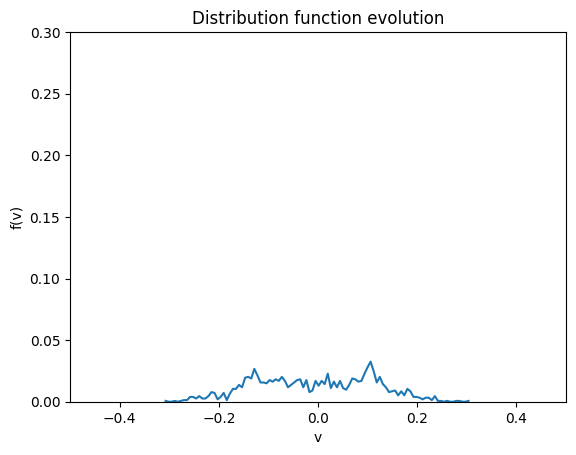

In [49]:
# Make video of the distribution function evolution over time 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

def velocity_distribution(v, num_bins=100):
    # Compute histogram of velocities
    counts, bins = np.histogram(v, bins=num_bins, density=True)
    
    # Normalize histogram to get probability distribution function
    distribution = counts / np.sum(counts)

    return bins, distribution

def distribution_video(v, num_bins=100):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Set axis limits
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 0.3)

    # Set labels
    ax.set_xlabel('v')
    ax.set_ylabel('f(v)')
    ax.set_title('Distribution function evolution')

    # Create initial plot
    bins, distribution = velocity_distribution(v[0])
    line, = ax.plot(bins[:-1], distribution)

    # Update function
    def update(frame):
        bins, distribution = velocity_distribution(v[frame])
        line.set_ydata(distribution)
        return line, 

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(v), blit=True)

    return ani

# Create video of the distribution function evolution over time
ani = distribution_video(yscat_0)
ani.save('distribution_function.mp4', writer='ffmpeg', fps=10)



In [49]:
# cycle through frames

for i in range(n_frames):


    # create figure

    fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(6,4))


    # plot line

    #axes.plot(xscat_0[0:i],yscat_0[0:i],lw=0.2,c='b')
    axes.scatter(xscat_0[i],yscat_0[i],s=1,c='b',edgecolors='k')


    # # set plot limits for momentum

    # axes.set_xlim(-0.08,0.08)
    # axes.set_ylim(-0.5,0.5)

    # set plot limits for position with rr

    axes.set_xlim(0,10)
    axes.set_ylim(0.22,0.27)


    # # set plot limits for position without rr

    # axes.set_xlim(0,20)
    # axes.set_ylim(0.22,0.27)

    #axes labels

    #title for position
    axes.set_title("Particles' positions at t = {:.1f}".format(i*dt)+"$\omega_p^{-1}$")

    # #title for momentum
    # axes.set_title("Evolution of particles' momentum")

    #axes label for position
    axes.set_xlabel("x1")
    axes.set_ylabel("x2")
    
    # #axes label for momentum
    # axes.set_xlabel("u1")
    # axes.set_ylabel("u2")
    

    # save frame

    fig.savefig(output_path+'frames/'+str(i)+'.png')
    plt.close()


    # print status

    print(str(i+1)+' of '+str(n_frames)+' frames ready!\t\t', end='\r')

In [50]:
# make movie

os.system('ffmpeg -framerate '+str(fps)+' -start_number 0 -i '+output_path+'frames/%01d.png -c:v libx264 -r '+str(fps)+' -pix_fmt yuv420p '+output_path+filename+'.mp4 -y')

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

0

In [51]:
# delete frames folder

os.system('rm -r '+output_path+'frames')

0

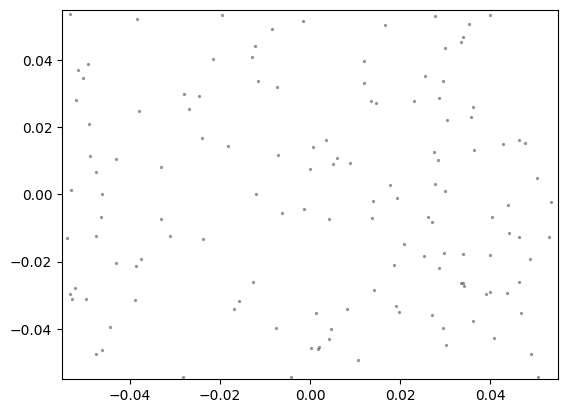

In [52]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
scatter = ax.scatter([], [], c="k", alpha=0.4, lw=0.1, s=5)

def update(frame):
    xscat_t = [x(ai) for ai in ele_part_rep[frame]]
    yscat_t = [y(ai) for ai in ele_part_rep[frame]]
    scatter.set_offsets(list(zip(xscat_t, yscat_t)))
    return scatter,

# Set the number of frames equal to the number of time steps
num_frames = len(ele_part_rep)

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# To save the animation as a movie file (e.g., mp4)
ani.save('particle_animation.mp4', writer='ffmpeg', fps=10)

# To display the animation
plt.show()

#### Single particle behaviour

The trajectory of a single paticle can properly illustrate the phenomenon.

It starts in the middle of the bottle, and as it gets to regions of higher $B$ the perpendicular velocity increases and  the longitudinal velocity goes to zero, due to the conservation of magnetic momentum. This effect is clearly visible on the u1-x1 phasespace trajectory.
When it reaches 0, the particle bouces back until it reaches the other end of the bottle.

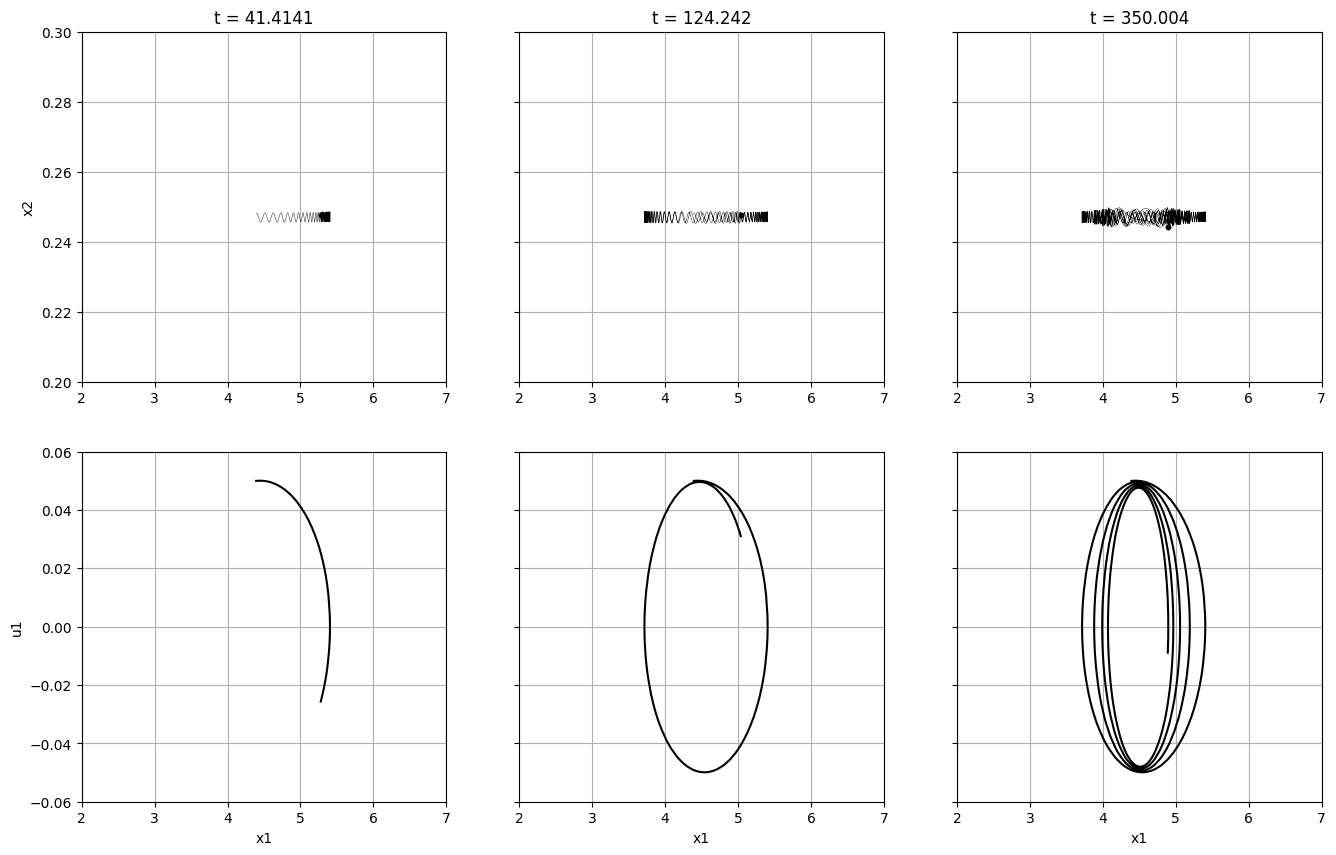

In [53]:
a=np.transpose(ele_part_rep)


import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[12]]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[12]]

# Extract the energy of particles from the trajectories
e_gamma_t = [np.sqrt(1.0+i['ux']**2+i['uy']**2+i['uz']**2) for i in a[12]]

#create time array
t=np.linspace(0,sim.t,sim.n)

axes[0,0].plot(e_posx_t[:300],e_posy_t[:300],c="k",lw=0.3)
axes[0,0].scatter(e_posx_t[300-1],e_posy_t[300-1],c="k",lw=0.3,s=15)
axes[0,1].plot(e_posx_t[:900],e_posy_t[:900],c="k",lw=0.3)
axes[0,1].scatter(e_posx_t[900-1],e_posy_t[900-1],c="k",lw=0.3,s=15)
axes[0,0].set_ylabel("x2")

axes[0,2].plot(e_posx_t[:-1],e_posy_t[:-1],c="k",lw=0.3)
axes[0,2].scatter(e_posx_t[-2],e_posy_t[-2],c="k",lw=0.3,s=15)

axes[0,0].set_title("t = {:g}".format(dt*3000))
axes[0,1].set_yticklabels([])
axes[0,1].set_title("t = {:g}".format(dt*9000))
axes[0,2].set_yticklabels([])
axes[0,2].set_title("t = {:g}".format(dt*sim.n))


e_ux_t=[i["ux"] for i in a[12]]
e_uy_t=[i["uz"] for i in a[12]]

axes[1,0].plot(e_posx_t[:300],e_ux_t[:300],c="k")
axes[1,1].plot(e_posx_t[:900],e_ux_t[:900],c="k")
axes[1,2].plot(e_posx_t[:-1],e_ux_t[:-1],c="k")
axes[1,0].set_ylabel("u1")

axes[1,1].set_yticklabels([])
axes[1,2].set_yticklabels([])

for ax in axes:
    for ax_ in ax:
        ax_.set_ylim(0.2,0.3)
        ax_.set_xlim(2,7)
        ax_.axvline(9,ls="--",c="r")
        ax_.grid()

for ax in axes[1,:]:
    ax.set_xlabel("x1")
    ax.set_ylim(-0.06,0.06)
    
plt.show()

In [54]:
# # Extract the energy of particles from the trajectories
# from ctypes import sizeof


# e_gamma_t = [np.sqrt(1.0+i['ux']**2+i['uy']**2+i['uz']**2) for i in ele_part_rep]
# #create time array
# t=np.linspace(0,150,1087)

# plt.plot(t,e_gamma_t)

#### Full picture

Looking at the trajecotries from all the particles in the bottle, we see that some particles bounce back before
the end of the bottle (in red, dashed), while others are able to go past the current loop without being reflected.

In [55]:
bound_idx=[]
unbound_idx=[]
for j in range(len(electrons.particles))[::]:
    if (a[j][-1]['ix']+a[j][-1]['x'])*box[0]/nx[0]>9 or min(a[j]["ux"])>0:
        unbound_idx.append(j)
    else:
        bound_idx.append(j)

Here we plot these two groups of particles separately

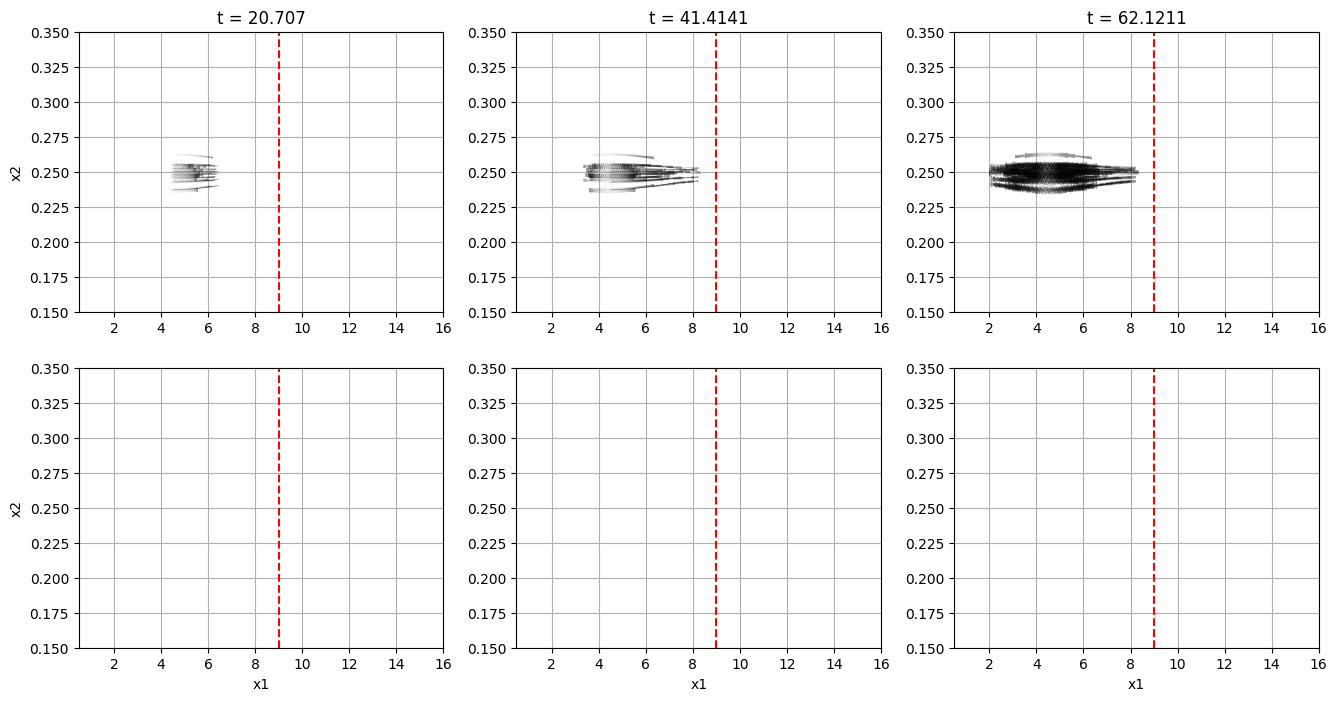

In [56]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

tstep=-1
for j in bound_idx[::32]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[j][:tstep]]
    axes[0,0].plot(e_posx_t[:300],e_posy_t[:300],c="k",alpha=0.4,lw=0.1)
    axes[0,1].plot(e_posx_t[:900],e_posy_t[:900],c="k",alpha=0.4,lw=0.1)
    axes[0,2].plot(e_posx_t,e_posy_t,c="k",alpha=0.4,lw=0.1)

axes[0,0].set_title("t = {:g}".format(dt*1500))
axes[0,1].set_title("t = {:g}".format(dt*3000))
axes[0,2].set_title("t = {:g}".format(dt*4500))

for j in unbound_idx[::16]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[j][:tstep]]
    axes[1,0].plot(e_posx_t[:300],e_posy_t[:300],c="r",alpha=0.4,lw=0.1)
    axes[1,1].plot(e_posx_t[:900],e_posy_t[:900],c="r",alpha=0.4,lw=0.1)
    axes[1,2].plot(e_posx_t,e_posy_t,c="r",alpha=0.4,lw=0.1)

for ax in axes[1]:
    ax.set_xlabel("x1")

for ax in axes[:,0]:
    ax.set_ylabel("x2")

for ax in axes:
    for ax_ in ax:
        ax_.set_ylim(0.15,0.35)
        ax_.set_xlim(0.5,16)
        ax_.axvline(9,ls="--",c="r")
        ax_.grid()

plt.show()

Here we plot the u1-x1 phasespace trajectories, where you can see that the trapped particles' longitudinal velocity (in black) periodically goes from positive to negative values, whereas the free particles long velocity (in red) never goes below 0.

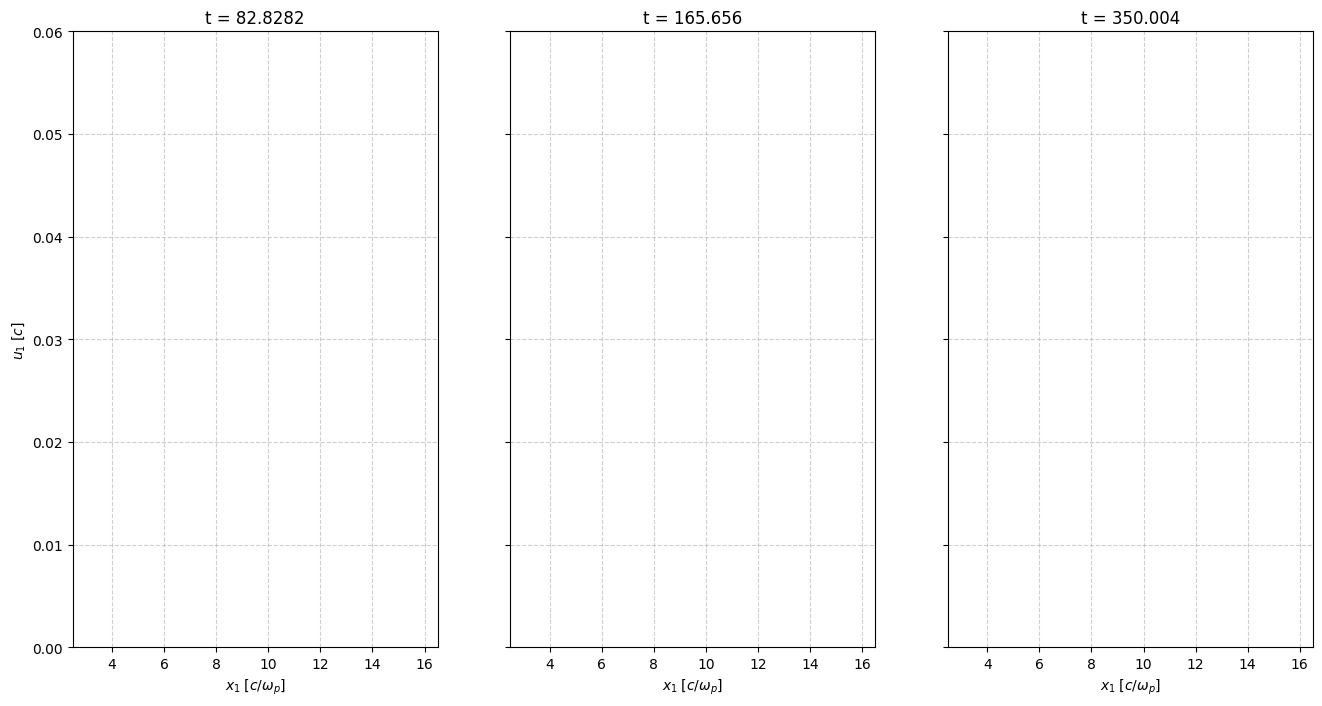

In [57]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

for ax in axes:
        ax.set_ylim(0.0,0.06)
        ax.set_xlim(2.5,16.5)
        ax.set_xlabel("$x_1\;[c/\omega_p]$")
        ax.grid(alpha=0.6,ls="--")

axes[0].set_title("t = {:g}".format(dt*6000))
axes[0].set_ylabel("$u_1\;[c]$")
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*12000))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))


for j in unbound_idx[::]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[i['ux'] for i in a[j][:tstep]]
    axes[0].plot(e_posx_t[:600],e_posy_t[:600],c="r",alpha=0.4,lw=0.1)
    axes[1].plot(e_posx_t[:1200],e_posy_t[:1200],c="r",alpha=0.4,lw=0.1)
    axes[2].plot(e_posx_t,e_posy_t,c="r",alpha=0.4,lw=0.1)


plt.show()

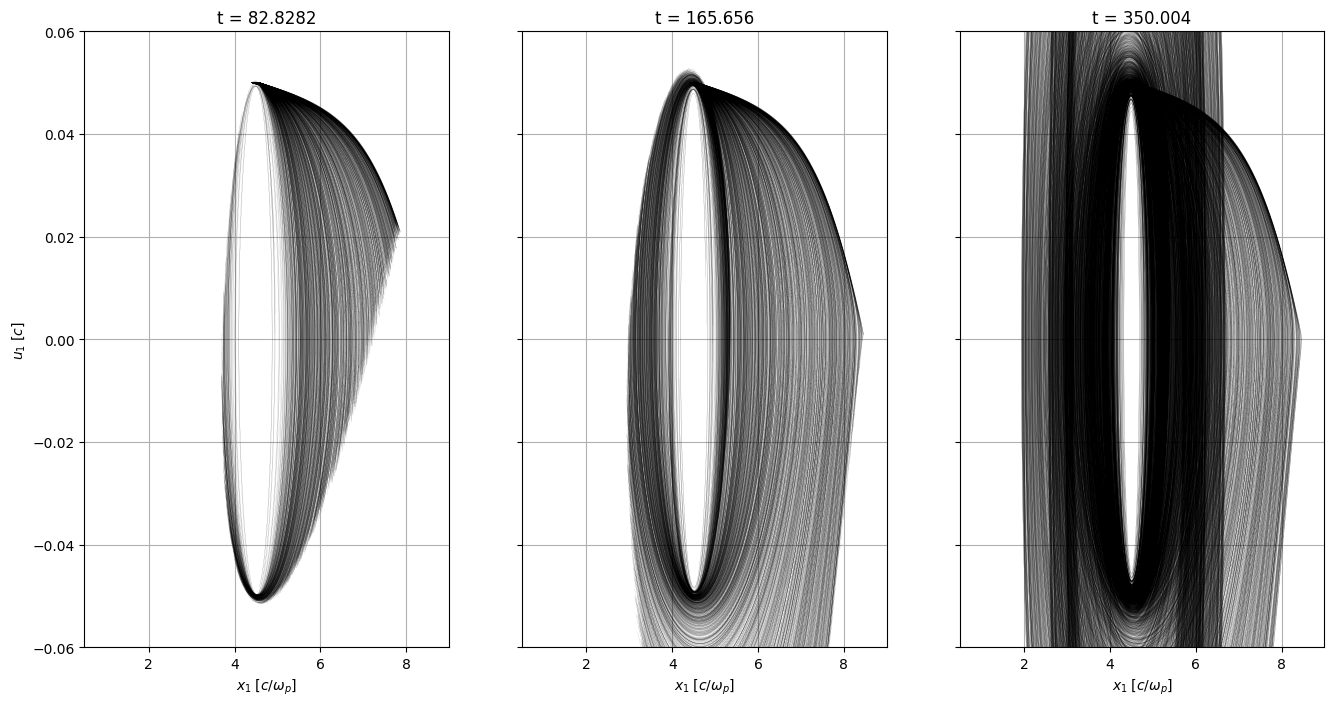

In [58]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


for j in bound_idx[::]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[i['ux'] for i in a[j][:tstep]]
    axes[0].plot(e_posx_t[:600],e_posy_t[:600],c="k",alpha=0.4,lw=0.1)
    axes[1].plot(e_posx_t[:1200],e_posy_t[:1200],c="k",alpha=0.4,lw=0.1)
    axes[2].plot(e_posx_t,e_posy_t,c="k",alpha=0.4,lw=0.1)

axes[0].set_title("t = {:g}".format(dt*6000))
axes[0].set_ylabel("$u_1\;[c]$")
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*12000))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))

for ax in axes:
        ax.set_ylim(-0.06,0.06)
        ax.set_xlim(0.5,9)
        ax.set_xlabel("$x_1\;[c/\omega_p]$")
        ax.grid()

plt.show()

This clear distinction can also be observed in the $u_y$ histogram. All particles have the same long. velocity so only particles with high enough $u_y$ are trapped.

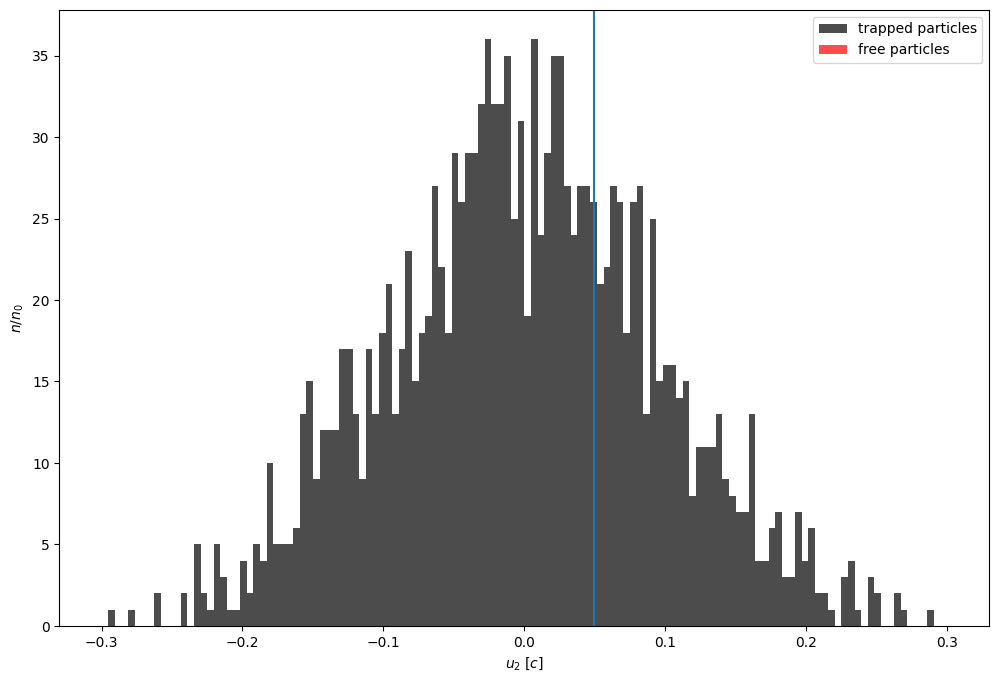

In [59]:
umax = 0.3
nbins = 128

plt.figure(figsize=(12,8))

bound_ux=[a[i][0]['uy'] for i in bound_idx]

plt.hist( bound_ux, bins = nbins, range = (-umax, umax),  label ='trapped particles' ,alpha=0.7,color="k")

unbound_ux=[a[i][0]['uy'] for i in unbound_idx]

plt.hist( unbound_ux, bins = nbins, range = (-umax, umax),  label ='free particles' ,alpha=0.7,color="r")


plt.xlabel("$ u_2\;[c] $")
plt.ylabel("$ n / n_0 $")
plt.axvline(0.05*np.tan(np.arcsin(np.sqrt(np.sqrt(np.min(np.array(external_fld)[:150,16,0])/np.max(np.array(external_fld)[:,16,0]))))))
plt.legend()
plt.show()

***
***